# Imports

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable, Any
import json
import random

import yaml
from tqdm import tqdm
from muutils.errormode import ErrorMode
from muutils.misc import shorten_numerical_to_str

from maze_dataset.tokenization import (
    MazeTokenizerModular,
    TokenizerElement,
    MazeTokenizer,
    TokenizationMode,
    CoordTokenizers,
    PromptSequencers,
    AdjListTokenizers,
    PathTokenizers,
    TargetTokenizers,
)

import maze_dataset.tokenization as md_tokenization

from maze_dataset import (
    VOCAB,
    VOCAB_LIST,
    VOCAB_TOKEN_TO_INDEX,
    LatticeMazeGenerators,
    MazeDataset,
    MazeDatasetConfig,
    SolvedMaze,
)

from maze_dataset.plotting import MazePlot

from maze_dataset.util import equal_except_adj_list_sequence

from maze_dataset.utils import all_instances

In [2]:
# magic autoreload
%load_ext autoreload
%autoreload 2

# `MazeTokenizerModular` Initialization

Most of the API for these tokenizers is contained in the `MazeTokenizerModular` class. The only time when users need to interact with the internal components of a `MazeTokenizerModular` is when initializing a non-default tokenizer.

In [3]:
mt_default: MazeTokenizerModular = MazeTokenizerModular()
mt_ctt: MazeTokenizerModular = MazeTokenizerModular.from_legacy(TokenizationMode.AOTP_CTT_indexed)
# mt_default, mt_ctt

The internal components of `MazeTokenizerModular` are all instances of `TokenizerElement`.

In [4]:
print("\n".join([str(elem) for elem in TokenizerElement.__subclasses__()]))

print('\nAOTP TokenizerElement Structure:\n')
print(mt_default.tokenizer_element_tree(abstract=True))
print(f'Default tokenizer elements:\n')
print(mt_default.tokenizer_element_tree())
print(yaml.dump(mt_default.tokenizer_element_dict()))

<class 'maze_dataset.tokenization.maze_tokenizer.CoordTokenizers._CoordTokenizer'>
<class 'maze_dataset.tokenization.maze_tokenizer.EdgeGroupings._EdgeGrouping'>
<class 'maze_dataset.tokenization.maze_tokenizer.EdgePermuters._EdgePermuter'>
<class 'maze_dataset.tokenization.maze_tokenizer.EdgeSubsets._EdgeSubset'>
<class 'maze_dataset.tokenization.maze_tokenizer.AdjListTokenizers._AdjListTokenizer'>
<class 'maze_dataset.tokenization.maze_tokenizer.TargetTokenizers._TargetTokenizer'>
<class 'maze_dataset.tokenization.maze_tokenizer.StepSizes._StepSize'>
<class 'maze_dataset.tokenization.maze_tokenizer.StepTokenizers._StepTokenizer'>
<class 'maze_dataset.tokenization.maze_tokenizer.PathTokenizers._PathTokenizer'>
<class 'maze_dataset.tokenization.maze_tokenizer.PromptSequencers._PromptSequencer'>

AOTP TokenizerElement Structure:

MazeTokenizerModular
	_PromptSequencer
		_CoordTokenizer
		_AdjListTokenizer
			_EdgeGrouping
			_EdgeSubset
			_EdgePermuter
		_TargetTokenizer
		_PathTokeniz

There are currently no other constructor methods. To construct a `MazeTokenizerModular` with other `TokenizerElement`s besides those available via `from_legacy`, the standard constructor with all parent `TokenizerElement`s in the tree must be used. Some `TokenizerElement`s also contain their own initialization arguments, most of which are `boolean`-typed. The most common arguments across all `TokenizerElement`s are named `pre`, `intra`, and `post`, which all control the option to add delimiter tokens to that part of the output. Other args are more specialized; see the class docstrings for more details.

# Vocabulary

All instances of `MazeTokenizerModular` uses a static vocabulary `VOCAB`, which is one of the main functional differences from `MazeTokenizer`. Direct access to the static vocabulary can be made through 3 constants:
- `VOCAB`
  - Extension of the `SPECIAL_TOKENS` dataclass
  - Supports direct property attribution
- `VOCAB_LIST: list[str]`
  - Contains the vocabulary in a list
  - Index of a token is its unique ID
- `VOCAB_TOKEN_TO_INDEX: dict[str, int]`
  - Inverse mapping of `VOCAB_LIST`, maps tokens to unique IDs

The following shows a visualizaiton of the first 5 elements of each constant.

In [5]:
print("`VOCAB`: type")
for i, t in enumerate(VOCAB):
    if i >= 5: break
    print(f"\tVOCAB.{t} = '{getattr(VOCAB, t)}'")
print('\t...')

print("\n`VOCAB_LIST`: list[str]")
for t in VOCAB_LIST[:5]:
    print(f"\t'{t}'")
print('\t...')
    
print("\n`VOCAB_TOKEN_TO_INDEX`: dict[str, int]")
for t in VOCAB_TOKEN_TO_INDEX:
    if VOCAB_TOKEN_TO_INDEX[t] >= 5: break
    print(f"\t'{t}':   \t{VOCAB_TOKEN_TO_INDEX[t]}")
print('\t...')


`VOCAB`: type
	VOCAB.ADJLIST_START = '<ADJLIST_START>'
	VOCAB.ADJLIST_END = '<ADJLIST_END>'
	VOCAB.TARGET_START = '<TARGET_START>'
	VOCAB.TARGET_END = '<TARGET_END>'
	VOCAB.ORIGIN_START = '<ORIGIN_START>'
	...

`VOCAB_LIST`: list[str]
	'<ADJLIST_START>'
	'<ADJLIST_END>'
	'<TARGET_START>'
	'<TARGET_END>'
	'<ORIGIN_START>'
	...

`VOCAB_TOKEN_TO_INDEX`: dict[str, int]
	'<ADJLIST_START>':   	0
	'<ADJLIST_END>':   	1
	'<TARGET_START>':   	2
	'<TARGET_END>':   	3
	'<ORIGIN_START>':   	4
	...


### Considerations of Static Vocabulary

- No more rasterized vs uniform indexing, it's all fixed as uniform now
- Fixed max grid size
  - There is now a fixed maximum maze size which is supported.
  - Unique tokens (`CoordTokenizers.UT`): 50x50
  - Coordinate tuple tokens (`CoordTokenizers.CTT`): 128x128
  - Mazes larger than these sizes are not supported
  - There should be fewer compatibility issues with tokenizers using different `max_grid_size` parameters
- Vocabulary access
  - Since maze-dataset 1.0, there is no need to pass around a tokenizer object or any data structure to access its custom vocabulary

### Refactoring your code from legacy `MazeTokenizer` and `TokenizationMode`
Since `MazeTokenizerModular` uses a static vocabulary, it is not backwards compatible with any models trained using a legacy `MazeTokenizer`. The `maze-transformer` library will be updated in vX.X.X to use `MazeTokenizerModular` by default in all settings. 

If you've manually specified a `MazeTokenizer` or `TokenizationMode` in your research code, the easiest way to refactor is using `MazeTokenizerModular.from_legacy`, which will convert a `MazeTokenizer` or `TokenizationMode` to its corresponding `MazeTokenizerModular` instance. Note that this correspondence means only that the stringification of mazes are equivalent; the encodings of strings to integer vocabulary indices are not.

In [6]:
legacy_maze_tokenizer: MazeTokenizer = TokenizationMode.AOTP_UT_uniform.to_legacy_tokenizer()
modular_tokenizer_equivalent: MazeTokenizerModular = MazeTokenizerModular.from_legacy(legacy_maze_tokenizer)
print(legacy_maze_tokenizer, '\n', modular_tokenizer_equivalent)


MazeTokenizer(tokenization_mode=<TokenizationMode.AOTP_UT_uniform: 'AOTP_UT_uniform'>, max_grid_size=None) 
 MazeTokenizerModular(prompt_sequencer=PromptSequencers.AOTP(coord_tokenizer=CoordTokenizers.UT(), adj_list_tokenizer=AdjListTokenizers.AdjListCoord(pre=False, post=True, shuffle_d0=True, edge_grouping=EdgeGroupings.Ungrouped(connection_token_ordinal=1), edge_subset=EdgeSubsets.ConnectionEdges(walls=False), edge_permuter=EdgePermuters.RandomCoords()), target_tokenizer=TargetTokenizers.Unlabeled(post=False), path_tokenizer=PathTokenizers.StepSequence(step_size=StepSizes.Singles(), step_tokenizers=(StepTokenizers.Coord(),), pre=False, intra=False, post=False)))


## `get_all_tokenizers`

Most combinations of `TokenizerElement`s and their arguments will produce a valid and unique `MazeTokenizerModular`. However, it is not guaranteed that every possible `MazeTokenizerModular` that can be constructed will make practical sense or have been put through testing.

`get_all_tokenizers` constructs and caches all the tested tokenizers at once. For research investigating many different tokenization schemes, one practical way to access them is by looping through/sampling from `get_all_tokenizers()`. Be aware that the indexing of specific tokenizers may change without notice.

In [7]:
# TODO: this cell fails because all_tokenizers is broken and takes too long. we kill it after a minute to give helpful error messages of where the long (infinite?) loop is.
from maze_dataset.tokenization.all_tokenizers import get_all_tokenizers

# import threading
# import time
# import signal

# interrupt after a fixed time
# def send_interrupt():
# 	time.sleep(60)
# 	signal.raise_signal(signal.SIGINT)

# interrupt_thread = threading.Thread(target=send_interrupt)
# interrupt_thread.start()
# fancy_timeit_result = timeit_fancy(get_all_tokenizers, repeats=1, do_profiling=True, get_return=True, namespace=locals())

# ALL_TOKENIZERS: list[MazeTokenizerModular] = get_all_tokenizers()
print(f"{len(get_all_tokenizers())} or {shorten_numerical_to_str(len(get_all_tokenizers()))} tokenizers found.")

C:\Users\aaron\Desktop\NTFS\dev\Unsearch\maze-dataset\maze_dataset\tokenization\maze_tokenizer.py:1023: UserWarning: no validation implemented for AdjListTokenizers
  warnings.warn(


4105728 or 4.1M tokenizers found.


In [8]:


cfg: MazeDatasetConfig = MazeDatasetConfig(
    name="test",
    grid_n=3,
    n_mazes=1,
    maze_ctor=LatticeMazeGenerators.gen_dfs,
)
maze_dataset: MazeDataset = MazeDataset.from_config(
    cfg,
    do_download=False,
    load_local=False,
    do_generate=True,
    save_local=False,
    verbose=True,
    gen_parallel=False,
)

trying to get the dataset 'test-g3-n1-a_dfs-h50097'
generating dataset...


generating & solving mazes: 100%|██████████| 1/1 [00:00<00:00, 43.64maze/s]

Got dataset test with 1 items. output.cfg.to_fname() = 'test-g3-n1-a_dfs-h50097'


Other possible tokenizers which aren't in `ALL_TOKENIZERS` are not guaranteed to function. Since

In [14]:
custom_tokenizer = MazeTokenizerModular(
    prompt_sequencer=PromptSequencers.AOP(),
)

assert not custom_tokenizer.is_tested_tokenizer()  # Danger, use this tokenizer at your own risk!

# Filtering Tokenizer Collections

There are a few practical ways to filter down a collection of tokenizers, or alternatively, generate a new collection with a filter.

1. `MazeTokenizerModular.has_element`
    - Use case: Concise, basic filtering on an existing collection
1. `MazeTokenizerModular.summary`
    - Use case: More precise filtering on an existing collection
1. `utils.all_instances`
    - Use case: Generate a new collection with filter.
    - For collections much smaller than the length of `get_all_tokenizers`, this can be much faster than filtering `get_all_tokenizers`

In [ ]:
len_all = len(get_all_tokenizers())
_n_digits = len(str(len_all))


# TokenizerElement Behavior Reference

For each primary `TokenizerElement`, tokenizations and encodings derived from the below maze are logged in DataFrames for reference.

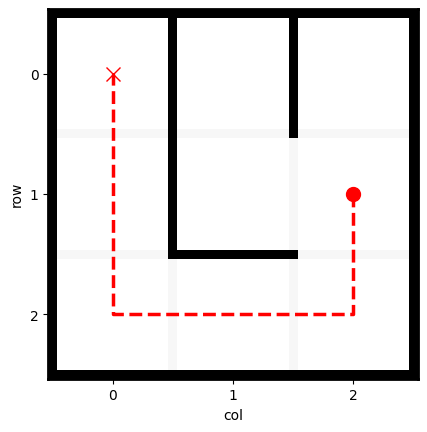

In [67]:
pd.set_option('display.max_colwidth', None)
mz: SolvedMaze = maze_dataset[0]
MazePlot(mz).plot()
plt.show()

In [68]:
def all_elements_df(elem_type: type[TokenizerElement], encoding=True, **to_tokens_kwargs):
    columns = ["TokenizerElement", "tokens"]
    if encoding:
        columns.append("encoding")
    tokenizers: pd.DataFrame = pd.DataFrame(columns=columns)

    tokenizers["TokenizerElement"] = list(all_instances(elem_type, validation_funcs={TokenizerElement: lambda x: x.is_valid()}))
    tokenizers["tokens"] = tokenizers["TokenizerElement"].apply(lambda x: " ".join(x.to_tokens(**to_tokens_kwargs)))
    if encoding:
        tokenizers["encoding"] = tokenizers["tokens"].apply(lambda x: MazeTokenizerModular.encode(x))
    return tokenizers

## `CoordTokenizers`

In [74]:
coord_tokenizers = all_elements_df(CoordTokenizers._CoordTokenizer, coord=mz.solution[0])
coord_tokenizers

,TokenizerElement,tokens,encoding
0,UT(),"(1,2)",[1602]
1,"CTT(pre=T, intra=T, post=T)","( 1 , 2 )","[11, 321, 12, 322, 13]"
2,"CTT(pre=T, intra=T, post=F)","( 1 , 2","[11, 321, 12, 322]"
3,"CTT(pre=T, intra=F, post=T)",( 1 2 ),"[11, 321, 322, 13]"
4,"CTT(pre=T, intra=F, post=F)",( 1 2,"[11, 321, 322]"
5,"CTT(pre=F, intra=T, post=T)","1 , 2 )","[321, 12, 322, 13]"
6,"CTT(pre=F, intra=T, post=F)","1 , 2","[321, 12, 322]"
7,"CTT(pre=F, intra=F, post=T)",1 2 ),"[321, 322, 13]"
8,"CTT(pre=F, intra=F, post=F)",1 2,"[321, 322]"


## Adjacency List Tokenizers

In [75]:
adjlist_tokenizers = all_elements_df(AdjListTokenizers._AdjListTokenizer, encoding=False, maze=mz, coord_tokenizer=CoordTokenizers.UT())
adjlist_tokenizers

C:\Users\aaron\Desktop\NTFS\dev\Unsearch\maze-dataset\maze_dataset\tokenization\maze_tokenizer.py:1023: UserWarning: no validation implemented for AdjListTokenizers
  warnings.warn(


,TokenizerElement,tokens
0,"AdjListCoord(pre=T, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=0), AllLatticeEdges(), SortedCoords())","ADJ_GROUP <XX> (0,0) (0,1) ; ADJ_GROUP <--> (0,0) (1,0) ; ADJ_GROUP <XX> (0,1) (0,2) ; ADJ_GROUP <--> (0,1) (1,1) ; ADJ_GROUP <--> (0,2) (1,2) ; ADJ_GROUP <XX> (1,0) (1,1) ; ADJ_GROUP <--> (1,0) (2,0) ; ADJ_GROUP <--> (1,1) (1,2) ; ADJ_GROUP <XX> (1,1) (2,1) ; ADJ_GROUP <--> (1,2) (2,2) ; ADJ_GROUP <--> (2,0) (2,1) ; ADJ_GROUP <--> (2,1) (2,2) ;"
1,"AdjListCoord(pre=T, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=0), AllLatticeEdges(), RandomCoords())","ADJ_GROUP <XX> (0,1) (0,0) ; ADJ_GROUP <XX> (0,2) (0,1) ; ADJ_GROUP <XX> (1,1) (1,0) ; ADJ_GROUP <--> (1,2) (1,1) ; ADJ_GROUP <--> (2,1) (2,0) ; ADJ_GROUP <--> (2,2) (2,1) ; ADJ_GROUP <--> (1,0) (0,0) ; ADJ_GROUP <--> (1,1) (0,1) ; ADJ_GROUP <--> (1,2) (0,2) ; ADJ_GROUP <--> (2,0) (1,0) ; ADJ_GROUP <XX> (2,1) (1,1) ; ADJ_GROUP <--> (2,2) (1,2) ;"
2,"AdjListCoord(pre=T, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=0), AllLatticeEdges(), BothCoords())","ADJ_GROUP <XX> (0,0) (0,1) ; ADJ_GROUP <XX> (0,1) (0,2) ; ADJ_GROUP <XX> (1,0) (1,1) ; ADJ_GROUP <--> (1,1) (1,2) ; ADJ_GROUP <--> (2,0) (2,1) ; ADJ_GROUP <--> (2,1) (2,2) ; ADJ_GROUP <--> (0,0) (1,0) ; ADJ_GROUP <--> (0,1) (1,1) ; ADJ_GROUP <--> (0,2) (1,2) ; ADJ_GROUP <--> (1,0) (2,0) ; ADJ_GROUP <XX> (1,1) (2,1) ; ADJ_GROUP <--> (1,2) (2,2) ; ADJ_GROUP <XX> (0,1) (0,0) ; ADJ_GROUP <XX> (0,2) (0,1) ; ADJ_GROUP <XX> (1,1) (1,0) ; ADJ_GROUP <--> (1,2) (1,1) ; ADJ_GROUP <--> (2,1) (2,0) ; ADJ_GROUP <--> (2,2) (2,1) ; ADJ_GROUP <--> (1,0) (0,0) ; ADJ_GROUP <--> (1,1) (0,1) ; ADJ_GROUP <--> (1,2) (0,2) ; ADJ_GROUP <--> (2,0) (1,0) ; ADJ_GROUP <XX> (2,1) (1,1) ; ADJ_GROUP <--> (2,2) (1,2) ;"
3,"AdjListCoord(pre=T, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=0), ConnectionEdges(walls=T), SortedCoords())","ADJ_GROUP <XX> (0,0) (0,1) ; ADJ_GROUP <XX> (0,1) (0,2) ; ADJ_GROUP <XX> (1,0) (1,1) ; ADJ_GROUP <XX> (1,1) (2,1) ;"
4,"AdjListCoord(pre=T, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=0), ConnectionEdges(walls=T), RandomCoords())","ADJ_GROUP <XX> (2,1) (1,1) ; ADJ_GROUP <XX> (0,1) (0,0) ; ADJ_GROUP <XX> (0,2) (0,1) ; ADJ_GROUP <XX> (1,1) (1,0) ;"
...,...,...
1579,"AdjListCardinal(pre=F, post=F, shuffle_d0=F, ByLeadingCoord(intra=F, shuffle_group=F, connection_token_ordinal=1), ConnectionEdges(walls=T), RandomCoords())","(0,1) WEST <XX> (0,2) WEST <XX> (1,1) WEST <XX> (2,1) NORTH <XX>"
1580,"AdjListCardinal(pre=F, post=F, shuffle_d0=F, ByLeadingCoord(intra=F, shuffle_group=F, connection_token_ordinal=1), ConnectionEdges(walls=T), BothCoords())","(0,0) EAST <XX> (0,1) WEST <XX> EAST <XX> (0,2) WEST <XX> (1,0) EAST <XX> (1,1) WEST <XX> SOUTH <XX> (2,1) NORTH <XX>"
1581,"AdjListCardinal(pre=F, post=F, shuffle_d0=F, ByLeadingCoord(intra=F, shuffle_group=F, connection_token_ordinal=1), ConnectionEdges(walls=F), SortedCoords())","(0,0) SOUTH <--> (0,1) SOUTH <--> (0,2) SOUTH <--> (1,0) SOUTH <--> (1,1) EAST <--> (1,2) SOUTH <--> (2,0) EAST <--> (2,1) EAST <-->"
1582,"AdjListCardinal(pre=F, post=F, shuffle_d0=F, ByLeadingCoord(intra=F, shuffle_group=F, connection_token_ordinal=1), ConnectionEdges(walls=F), RandomCoords())","(1,0) NORTH <--> (1,1) NORTH <--> (1,2) NORTH <--> WEST <--> (2,0) NORTH <--> (2,1) WEST <--> (2,2) NORTH <--> WEST <-->"


## Target Tokenizers

In [76]:
target_tokenizers = all_elements_df(TargetTokenizers._TargetTokenizer, targets=[mz.end_pos], coord_tokenizer=CoordTokenizers.UT())
target_tokenizers

,TokenizerElement,tokens,encoding
0,Unlabeled(post=T),"(0,0) ||","[1596, 15]"
1,Unlabeled(post=F),"(0,0)",[1596]


## Path Tokenizers

In [77]:
path_tokenizers = all_elements_df(PathTokenizers._PathTokenizer, maze=mz, coord_tokenizer=CoordTokenizers.UT())
path_tokenizers

,TokenizerElement,tokens,encoding
0,"StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=T, intra=T, post=T)","STEP (1,2) : STEP (2,2) : THEN STEP (2,1) : THEN STEP (2,0) : THEN STEP (1,0) : THEN STEP (0,0) : THEN","[704, 1602, 16, 704, 1604, 16, 17, 704, 1603, 16, 17, 704, 1601, 16, 17, 704, 1598, 16, 17, 704, 1596, 16, 17]"
1,"StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=T, intra=T, post=F)","STEP (1,2) : STEP (2,2) : STEP (2,1) : STEP (2,0) : STEP (1,0) : STEP (0,0) :","[704, 1602, 16, 704, 1604, 16, 704, 1603, 16, 704, 1601, 16, 704, 1598, 16, 704, 1596, 16]"
2,"StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=T, intra=F, post=T)","STEP (1,2) STEP (2,2) THEN STEP (2,1) THEN STEP (2,0) THEN STEP (1,0) THEN STEP (0,0) THEN","[704, 1602, 704, 1604, 17, 704, 1603, 17, 704, 1601, 17, 704, 1598, 17, 704, 1596, 17]"
3,"StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=T, intra=F, post=F)","STEP (1,2) STEP (2,2) STEP (2,1) STEP (2,0) STEP (1,0) STEP (0,0)","[704, 1602, 704, 1604, 704, 1603, 704, 1601, 704, 1598, 704, 1596]"
4,"StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=F, intra=T, post=T)","(1,2) : (2,2) : THEN (2,1) : THEN (2,0) : THEN (1,0) : THEN (0,0) : THEN","[1602, 16, 1604, 16, 17, 1603, 16, 17, 1601, 16, 17, 1598, 16, 17, 1596, 16, 17]"
...,...,...,...
91,"StepSequence(ForksAndStraightaways(), step_tokenizers=(Distance(), Coord(), ), pre=T, intra=F, post=F)","STEP (1,2) STEP +1 (2,2) STEP +2 (2,0) STEP +2 (0,0)","[704, 1602, 704, 65, 1604, 704, 66, 1601, 704, 66, 1596]"
92,"StepSequence(ForksAndStraightaways(), step_tokenizers=(Distance(), Coord(), ), pre=F, intra=T, post=T)","(1,2) : +1 : (2,2) : THEN +2 : (2,0) : THEN +2 : (0,0) : THEN","[1602, 16, 65, 16, 1604, 16, 17, 66, 16, 1601, 16, 17, 66, 16, 1596, 16, 17]"
93,"StepSequence(ForksAndStraightaways(), step_tokenizers=(Distance(), Coord(), ), pre=F, intra=T, post=F)","(1,2) : +1 : (2,2) : +2 : (2,0) : +2 : (0,0) :","[1602, 16, 65, 16, 1604, 16, 66, 16, 1601, 16, 66, 16, 1596, 16]"
94,"StepSequence(ForksAndStraightaways(), step_tokenizers=(Distance(), Coord(), ), pre=F, intra=F, post=T)","(1,2) +1 (2,2) THEN +2 (2,0) THEN +2 (0,0) THEN","[1602, 65, 1604, 17, 66, 1601, 17, 66, 1596, 17]"


## Prompt Sequencers

Currently, the only difference in possible prompt sequencers is the inclusion/exclusion of target tokens.

In [78]:
prompt_sequencers = [PromptSequencers.AOTP(), PromptSequencers.AOP()]
columns = ["TokenizerElement", "tokens"]
tokenizers: pd.DataFrame = pd.DataFrame(columns=columns)

tokenizers["TokenizerElement"] = prompt_sequencers
tokenizers["tokens"] = tokenizers["TokenizerElement"].apply(lambda x: " ".join(x.to_tokens(maze=mz)))
tokenizers

,TokenizerElement,tokens
0,"AOTP(UT(), AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=1), ConnectionEdges(walls=F), RandomCoords()), Unlabeled(post=F), StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=F, intra=F, post=F))","<ADJLIST_START> (0,0) <--> (1,0) ; (0,1) <--> (1,1) ; (0,2) <--> (1,2) ; (1,0) <--> (2,0) ; (1,2) <--> (2,2) ; (1,1) <--> (1,2) ; (2,0) <--> (2,1) ; (2,1) <--> (2,2) ; <ADJLIST_END> <ORIGIN_START> (1,2) <ORIGIN_END> <TARGET_START> (0,0) <TARGET_END> <PATH_START> (1,2) (2,2) (2,1) (2,0) (1,0) (0,0) <PATH_END>"
1,"AOP(UT(), AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=1), ConnectionEdges(walls=F), RandomCoords()), StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=F, intra=F, post=F))","<ADJLIST_START> (0,0) <--> (1,0) ; (0,1) <--> (1,1) ; (0,2) <--> (1,2) ; (1,0) <--> (2,0) ; (1,2) <--> (2,2) ; (1,1) <--> (1,2) ; (2,0) <--> (2,1) ; (2,1) <--> (2,2) ; <ADJLIST_END> <ORIGIN_START> (1,2) <ORIGIN_END> <TARGET_START> <TARGET_END> <PATH_START> (1,2) (2,2) (2,1) (2,0) (1,0) (0,0) <PATH_END>"


## Random Sample of `MazeTokenizerModular`s

In [100]:
random_sample_size: int = 1_000

tokenizers: list[MazeTokenizerModular] = random.sample(get_all_tokenizers(), random_sample_size)
columns = ["MazeTokenizerModular", "tokens", "encoding", *mt_default.summary().keys()]
df: pd.DataFrame = pd.DataFrame(columns=columns)

df["MazeTokenizerModular"] = tokenizers
df["tokens"] = df["MazeTokenizerModular"].apply(lambda x: " ".join(x.to_tokens(maze=mz)))
df.encoding = df.tokens.apply(MazeTokenizerModular.encode)

In [101]:

for k in tqdm(mt_default.summary().keys(), desc="Tokenizers", total=len(mt_default.summary())):
    df[k] = df.apply(lambda x: x.MazeTokenizerModular.summary()[k] if k in x.MazeTokenizerModular.summary() else None, axis=1)

pd.set_option('display.max_colwidth', 50)

df

Tokenizers: 100%|██████████| 10/10 [00:01<00:00,  7.75it/s]


,MazeTokenizerModular,tokens,encoding,prompt_sequencer,coord_tokenizer,adj_list_tokenizer,edge_grouping,edge_subset,edge_permuter,target_tokenizer,path_tokenizer,step_size,step_tokenizers
0,MazeTokenizerModular(prompt_sequencer=PromptSe...,<ADJLIST_START> ADJ_GROUP <XX> ( 0 0 ) ( 0 1 )...,"[0, 705, 707, 11, 320, 320, 13, 11, 320, 321, ...","AOTP(CTT(pre=T, intra=F, post=T), AdjListCoord...","CTT(pre=T, intra=F, post=T)","AdjListCoord(pre=T, post=T, shuffle_d0=F, Ungr...",Ungrouped(connection_token_ordinal=0),AllLatticeEdges(),BothCoords(),Unlabeled(post=F),"StepSequence(ForksAndStraightaways(), step_tok...",ForksAndStraightaways(),Coord()
1,MazeTokenizerModular(prompt_sequencer=PromptSe...,"<ADJLIST_START> 0 , 0 ) <XX> EAST & 0 , 1 ) <X...","[0, 320, 12, 320, 13, 707, 57, 706, 320, 12, 3...","AOP(CTT(pre=F, intra=T, post=T), AdjListCardin...","CTT(pre=F, intra=T, post=T)","AdjListCardinal(pre=F, post=F, shuffle_d0=T, B...","ByLeadingCoord(intra=T, shuffle_group=T, conne...",ConnectionEdges(walls=T),SortedCoords(),None,"StepSequence(ForksAndStraightaways(), step_tok...",ForksAndStraightaways(),Distance()
2,MazeTokenizerModular(prompt_sequencer=PromptSe...,<ADJLIST_START> 0 0 ) <XX> EAST 0 1 ) <XX> EAS...,"[0, 320, 320, 13, 707, 57, 320, 321, 13, 707, ...","AOP(CTT(pre=F, intra=F, post=T), AdjListCardin...","CTT(pre=F, intra=F, post=T)","AdjListCardinal(pre=F, post=F, shuffle_d0=F, U...",Ungrouped(connection_token_ordinal=1),AllLatticeEdges(),RandomCoords(),None,"StepSequence(Forks(), step_tokenizers=(Distanc...",Forks(),Coord()
3,MazeTokenizerModular(prompt_sequencer=PromptSe...,"<ADJLIST_START> ADJ_GROUP ( 0 , 0 EAST <XX> SO...","[0, 705, 11, 320, 12, 320, 57, 707, 56, 8, 705...","AOTP(CTT(pre=T, intra=T, post=F), AdjListCardi...","CTT(pre=T, intra=T, post=F)","AdjListCardinal(pre=T, post=F, shuffle_d0=T, B...","ByLeadingCoord(intra=F, shuffle_group=F, conne...",AllLatticeEdges(),BothCoords(),Unlabeled(post=T),"StepSequence(ForksAndStraightaways(), step_tok...",ForksAndStraightaways(),Coord()
4,MazeTokenizerModular(prompt_sequencer=PromptSe...,<ADJLIST_START> ADJ_GROUP 0 0 ) <--> SOUTH & ;...,"[0, 705, 320, 320, 13, 8, 56, 706, 9, 705, 320...","AOTP(CTT(pre=F, intra=F, post=T), AdjListCardi...","CTT(pre=F, intra=F, post=T)","AdjListCardinal(pre=T, post=T, shuffle_d0=T, B...","ByLeadingCoord(intra=T, shuffle_group=F, conne...",ConnectionEdges(walls=F),SortedCoords(),Unlabeled(post=F),"StepSequence(Singles(), step_tokenizers=(Coord...",Singles(),Coord()
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,MazeTokenizerModular(prompt_sequencer=PromptSe...,"<ADJLIST_START> ( 0 , 0 ) ( 1 , 0 ) <--> & ; (...","[0, 11, 320, 12, 320, 13, 11, 321, 12, 320, 13...","AOP(CTT(pre=T, intra=T, post=T), AdjListCoord(...","CTT(pre=T, intra=T, post=T)","AdjListCoord(pre=F, post=T, shuffle_d0=F, ByLe...","ByLeadingCoord(intra=T, shuffle_group=T, conne...",ConnectionEdges(walls=F),BothCoords(),None,"StepSequence(ForksAndStraightaways(), step_tok...",ForksAndStraightaways(),Coord()
996,MazeTokenizerModular(prompt_sequencer=PromptSe...,"<ADJLIST_START> ADJ_GROUP ( 0 , 0 ) <XX> EAST ...","[0, 705, 11, 320, 12, 320, 13, 707, 57, 706, 8...","AOP(CTT(pre=T, intra=T, post=T), AdjListCardin...","CTT(pre=T, intra=T, post=T)","AdjListCardinal(pre=T, post=T, shuffle_d0=F, B...","ByLeadingCoord(intra=T, shuffle_group=F, conne...",AllLatticeEdges(),BothCoords(),None,"StepSequence(ForksAndStraightaways(), step_tok...",ForksAndStraightaways(),Distance()
997,MazeTokenizerModular(prompt_sequencer=PromptSe...,"<ADJLIST_START> 0 , 0 ) SOUTH <--> & EAST <XX>...","[0, 320, 12, 320, 13, 56, 8, 706, 57, 707, 706...","AOP(CTT(pre=F, intra=T, post=T), AdjListCardin...","CTT(pre=F, intra=T, post=T)","AdjListCardinal(pre=F, post=F, shuffle_d0=T, B...","ByLeadingCoord(intra=T, shuffle_group=T, conne...",AllLatticeEdges(),RandomCoords(),None,"StepSequence(ForksAndStraightaways(), step_tok...",ForksAndStraightaways(),Coord()
998,MazeTokenizerModular(prompt_sequencer=Pr